In [1]:
import math
import os
import warnings

import dask.distributed
import matplotlib
import matplotlib.pyplot as plt
import ncar_jobqueue
import numpy as np
import xarray as xr

import utils
from utils.utils import time_set_mid, round_sig

%matplotlib inline
%load_ext autoreload
%autoreload 2


In [2]:
cluster = ncar_jobqueue.NCARCluster(
    cores=1, memory="24 GB", processes=1, walltime="6:00:00"
)
cluster.scale(n=16)  # n = number of workers
# cluster.adapt(maximum=16)
print(f"dashboard_link={cluster.dashboard_link}")
client = dask.distributed.Client(cluster)

dashboard_link=https://jupyterhub.ucar.edu/dav/user/klindsay/proxy/8787/status


In [3]:
casenames = [
    "g.e22.G1850ECO_JRA_HR.TL319_t13.003",
    "g.e22.G1850ECO_JRA_HR.TL319_t13.004",
]

ds_dict = {}

In [4]:
def var_lt_thres_area_sum(
    ds,
    varname,
    mask,
    thres_vals,
    region_mask_vals,
    isel_dict,
    cache_dir="cache",
    cache_clobber=False,
    **open_dataset_kwargs,
):
    cache_filename = gen_cache_filename(
        "var_lt_thres_area_sum", ds, varname, isel_dict
    )
    cache_path = os.path.join(cache_dir, cache_filename)
    print([cache_path, os.path.exists(cache_path)])
    if cache_clobber or not os.path.exists(cache_path):
        ds_out = var_lt_thres_area_sum_core(
            ds, varname, mask, thres_vals, region_mask_vals, isel_dict
        )
        ds_out.to_netcdf(cache_path)
    else:
        ds_out = xr.open_dataset(cache_path, **open_dataset_kwargs)

    return ds_out


def gen_cache_filename(fcn_name, ds, varname, isel_dict):
    # construct name of cache file
    cache_filename_terms = [fcn_name, ds.attrs["title"], varname]
    for isel_key, isel_val in isel_dict.items():
        cache_filename_terms.append(isel_key)
        if isinstance(isel_val, slice):
            cache_filename_terms.append(str(isel_val.start))
            cache_filename_terms.append(str(isel_val.stop))
            if isel_val.step is not None:
                cache_filename_terms.append(str(isel_val.step))
        else:
            cache_filename_terms.append(str(isel_val))
    return "_".join(cache_filename_terms) + ".nc"


def var_lt_thres_area_sum_core(
    ds, varname, mask, thres_vals, region_mask_vals, isel_dict
):
    # generate mask where ds[varname] < threshold values
    da = ds[varname].isel(isel_dict).expand_dims(dim={"thres": thres_vals})
    da_lt_thres_mask = xr.where((da < da.thres) & mask, 1.0, 0.0)

    region_mask = ds["REGION_MASK"]
    tarea = ds["TAREA"]

    # add region dimension
    da_lt_thres_mask = da_lt_thres_mask.expand_dims(
        dim={"region_mask": region_mask_vals}
    )
    da_lt_thres_mask.region_mask.encoding["dtype"] = "int32"
    da_lt_thres_mask_region = xr.where(
        region_mask == da_lt_thres_mask.region_mask, da_lt_thres_mask, 0.0
    )

    tb_name = ds["time"].attrs["bounds"]
    ds_out = ds[["time", tb_name, "dz"]].isel(isel_dict)
    for key in ["unlimited_dims"]:
        if key in ds.encoding:
            ds_out.encoding[key] = ds.encoding[key]

    varname_out = f"{varname}_lt_thres_area_sum"
    ds_out[varname_out] = (da_lt_thres_mask_region * tarea).sum(
        ["nlat", "nlon"]
    )

    return ds_out.transpose("time", ...)

In [5]:
region_mask_vals = [2, 3, 6]
thres_vals = [-0.1, 0.0, 5.0, 10.0, 20.0, 40.0]

In [6]:
for casename in casenames:
    campaign_root = os.path.join(
        os.sep,
        "glade",
        "campaign",
        "cesm",
        "development",
        "bgcwg",
        "projects",
        "hi-res_JRA",
        "cases",
    )
    output_roots = [os.path.join(campaign_root, casename, "output")]

    caseroot = os.path.join(
        os.sep, "glade", "work", "mlevy", "hi-res_BGC_JRA", "cases", casename
    )
    output_roots += utils.gen_output_roots_from_caseroot(caseroot)

    case = utils.CaseClass(casename, output_roots)

    chunks = {"time": 1, "z_t": 1}

    varname = "O2"
    ds = case.gen_dataset(
        varname,
        stream="pop.h",
        vars_to_keep=["dz", "REGION_MASK"],
        chunks=chunks,
    )

    mask = abs(ds["TLAT"]) < 30.0

    time_len = len(ds["time"])
    time_step = 12
    ds_list = []
    for t_ind in range(0, time_len, time_step):
        isel_dict = {"time": slice(t_ind, min(time_len, t_ind + time_step))}
        ds_out = var_lt_thres_area_sum(
            ds,
            varname=varname,
            mask=mask,
            thres_vals=thres_vals,
            region_mask_vals=region_mask_vals,
            isel_dict=isel_dict,
            chunks=chunks,
        )
        ds_list.append(ds_out)

    varname_out = f"{varname}_lt_thres_area_sum"
    ds_full = xr.concat(
        ds_list,
        dim="time",
        data_vars=[varname_out],
        coords="minimal",
        compat="override",
    ).compute()
    print(ds_full)
    ds_dict[casename] = ds_full

Datasets contain a total of 48 time samples
Last average written at 0005-01-01 00:00:00
['cache/var_lt_thres_area_sum_g.e22.G1850ECO_JRA_HR.TL319_t13.003_O2_time_0_12.nc', True]
['cache/var_lt_thres_area_sum_g.e22.G1850ECO_JRA_HR.TL319_t13.003_O2_time_12_24.nc', True]
['cache/var_lt_thres_area_sum_g.e22.G1850ECO_JRA_HR.TL319_t13.003_O2_time_24_36.nc', True]
['cache/var_lt_thres_area_sum_g.e22.G1850ECO_JRA_HR.TL319_t13.003_O2_time_36_48.nc', True]
<xarray.Dataset>
Dimensions:               (d2: 2, region_mask: 3, thres: 6, time: 48, z_t: 62)
Coordinates:
  * time                  (time) object 0001-01-16 12:15:50 ... 0004-12-16 12...
  * z_t                   (z_t) float32 500.0 1500.0 ... 562499.06 587499.06
  * region_mask           (region_mask) int32 2 3 6
  * thres                 (thres) float64 -0.1 0.0 5.0 10.0 20.0 40.0
Dimensions without coordinates: d2
Data variables:
    time_bound            (time, d2) object 0001-01-01 00:31:40 ... 0005-01-0...
    dz                    (z

In [7]:
client.close()
cluster.close()

In [8]:
def omz_plot(varname, region_mask_val):
    varname_out = f"{varname}_lt_thres_area_sum"
    depth_subset = slice(0.0, 2500.0e2)

    for thres_val in [0.0, 5.0, 10.0, 40.0]:
        sel_dict = {"region_mask": region_mask_val, "thres": thres_val}
        sel_dict["z_t"] = depth_subset
        print(sel_dict)

        # generate contour levels for time-depth contour plots
        # compute max over cases
        max_val = max(
            [
                ds_dict[casename].sel(sel_dict)[varname_out].max()
                for casename in casenames
            ]
        )
        level_delta = round_sig(max_val.values / 10, 2)
        nlevels = math.ceil(max_val / level_delta)
        levels = np.linspace(0.0, level_delta * nlevels, nlevels + 1)

        for casename in casenames:

            ds = ds_dict[casename].sel(sel_dict)
            da = ds[varname_out]

            # time-depth contour plot of area
            # ignore certain warnings
            with warnings.catch_warnings():
                warnings.filterwarnings(
                    action="ignore",
                    category=matplotlib.MatplotlibDeprecationWarning,
                )
                da.transpose("z_t", ...).plot.contourf(
                    cmap="Blues", levels=levels
                )
            plt.gca().invert_yaxis()
            title = f"Area, Basin Ind={region_mask_val}, thres={thres_val}\n{casename}"
            plt.title(title)
            plt.show()

            # timeseries plot of volume
            omz_vol = (da * ds["dz"]).sum("z_t")
            omz_vol.plot.line("-o")
            title = f"Volume, Basin Ind={region_mask_val}, thres={thres_val}\n{casename}"
            plt.title(title)
            plt.show()

            # timeseries plot of area-weighted average depth
            z_t_avg = (da * ds["z_t"]).sum("z_t") / da.sum("z_t")
            z_t_avg.plot.line("-o")
            title = f"Average Depth, Basin Ind={region_mask_val}, thres={thres_val}\n{casename}"
            plt.title(title)
            plt.show()

            # timeseries plot of area-weighted depth standard deviation
            z_t_variance = (da * (ds["z_t"] - z_t_avg) ** 2).sum(
                "z_t"
            ) / da.sum("z_t")
            z_t_sigma = np.sqrt(z_t_variance)
            z_t_sigma.plot.line("-o")
            title = f"Depth standard deviation, Basin Ind={region_mask_val}, thres={thres_val}\n{casename}"
            plt.title(title)
            plt.show()

    # average volume vs threshold, 1 line per year

    sel_dict = {"region_mask": region_mask_val}
    sel_dict["z_t"] = depth_subset
    time_step = 12
    for casename in casenames:
        ds = ds_dict[casename].sel(sel_dict)
        da_vol = (ds[varname_out] * ds["dz"]).sum("z_t")
        for t_ind in range(0, len(ds["time"]), time_step):
            isel_dict = {"time": slice(t_ind, t_ind + time_step)}
            da_vol.isel(isel_dict).mean("time").plot.line("-o")
        title = f"Volume, Basin Ind={region_mask_val}\n{casename}"
        plt.title(title)
        plt.show()

{'region_mask': 2, 'thres': 0.0, 'z_t': slice(0.0, 250000.0, None)}


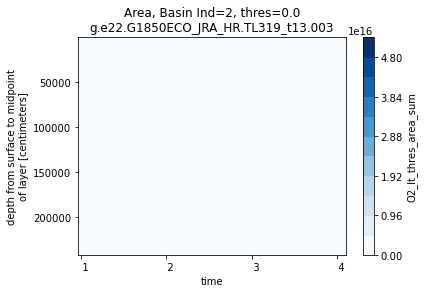

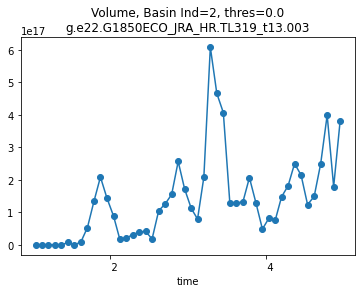

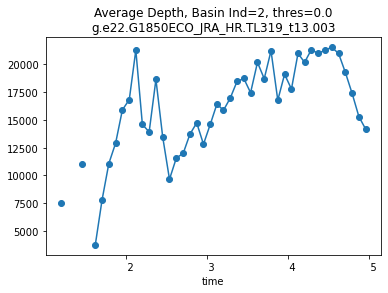

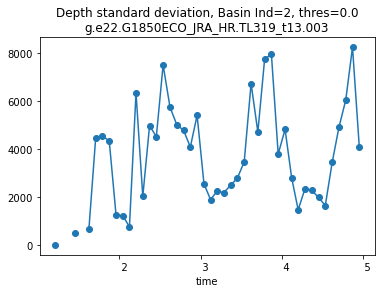

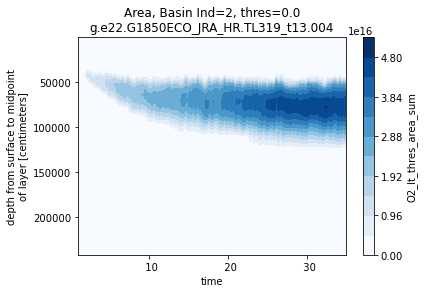

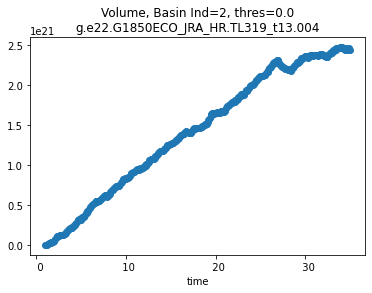

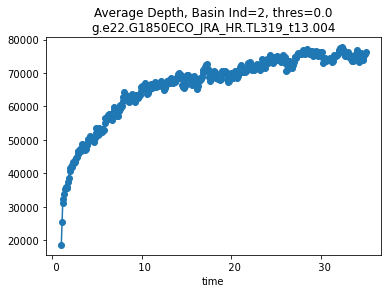

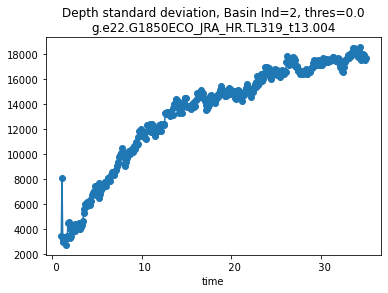

{'region_mask': 2, 'thres': 5.0, 'z_t': slice(0.0, 250000.0, None)}


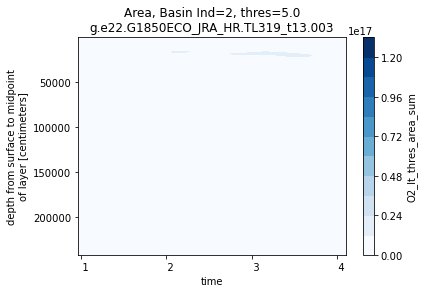

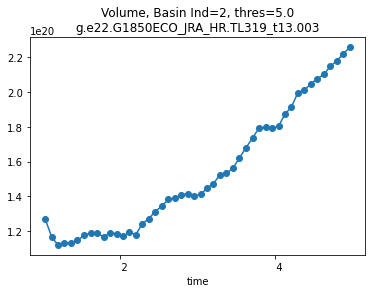

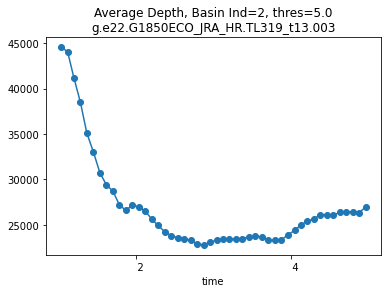

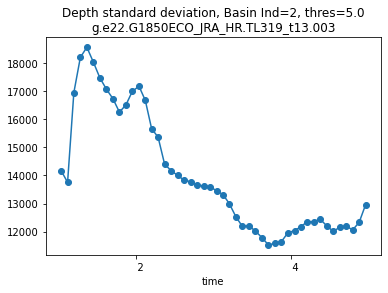

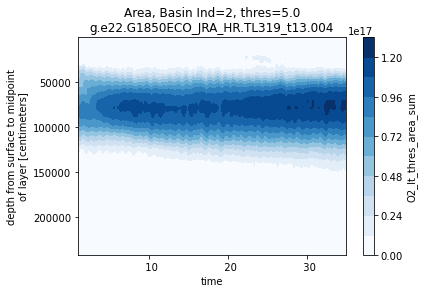

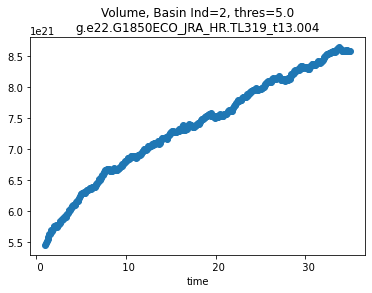

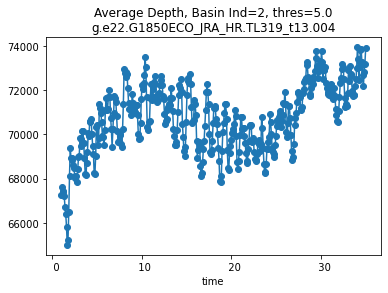

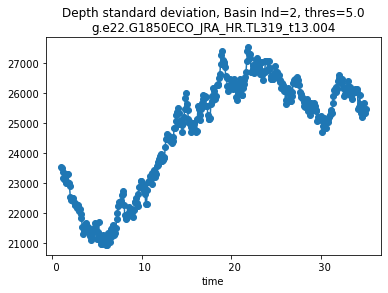

{'region_mask': 2, 'thres': 10.0, 'z_t': slice(0.0, 250000.0, None)}


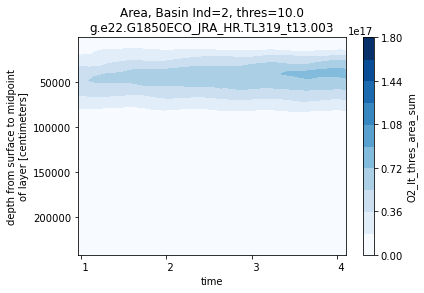

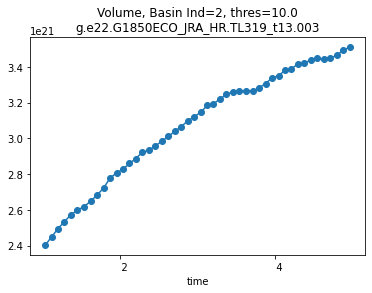

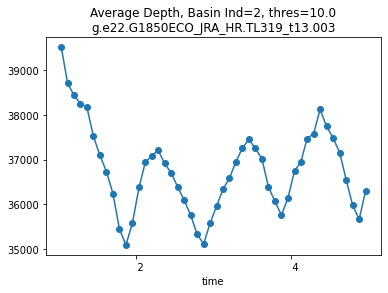

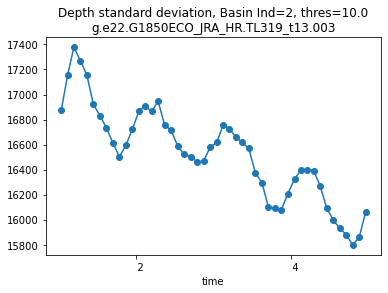

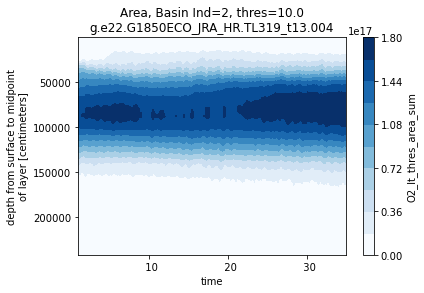

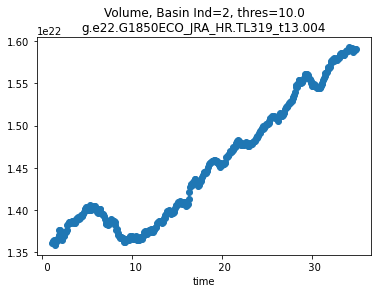

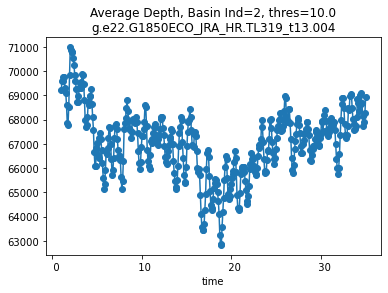

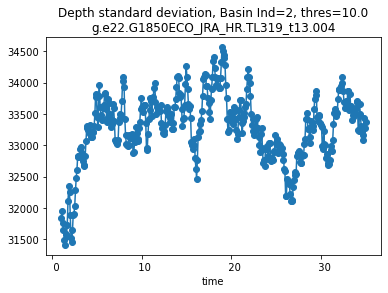

{'region_mask': 2, 'thres': 40.0, 'z_t': slice(0.0, 250000.0, None)}


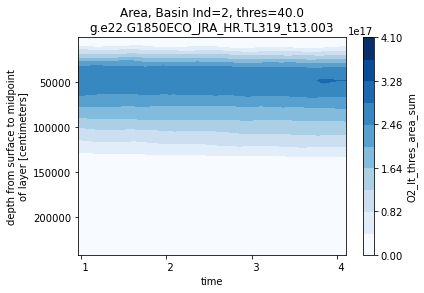

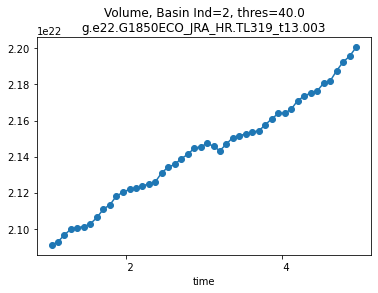

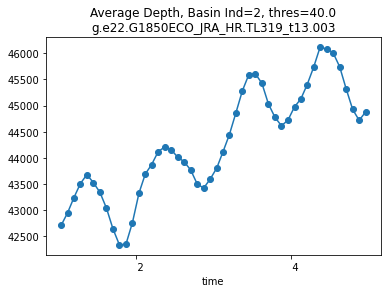

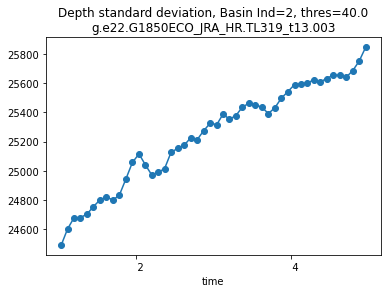

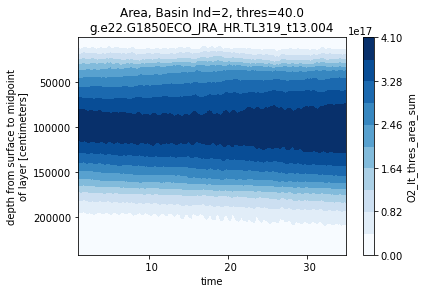

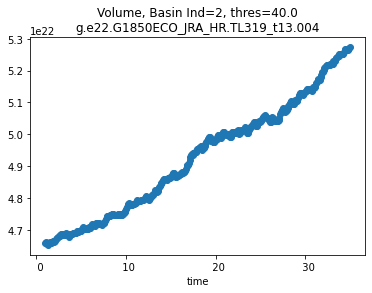

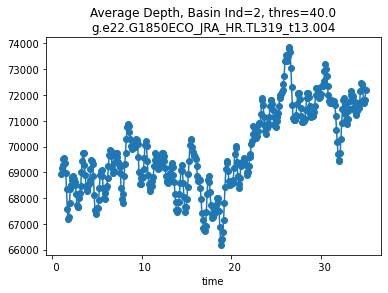

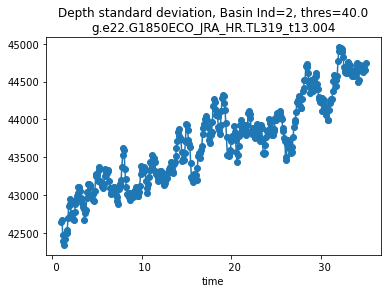

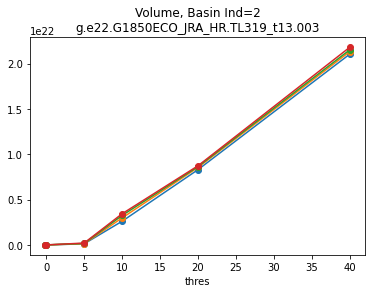

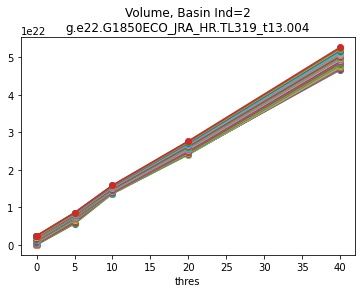

In [9]:
omz_plot(varname, region_mask_val=2)

{'region_mask': 3, 'thres': 0.0, 'z_t': slice(0.0, 250000.0, None)}


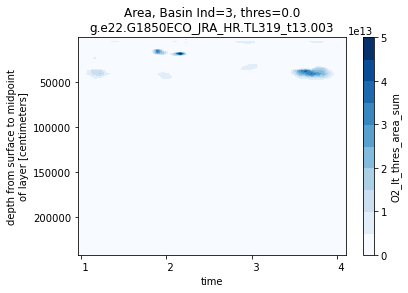

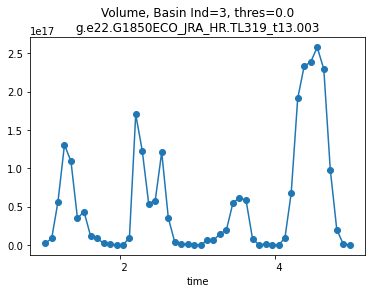

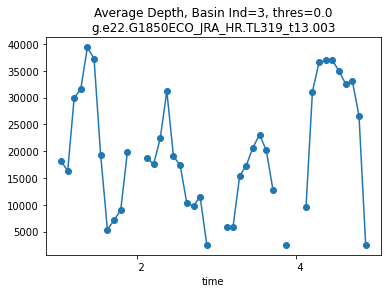

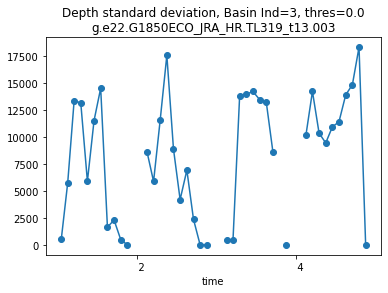

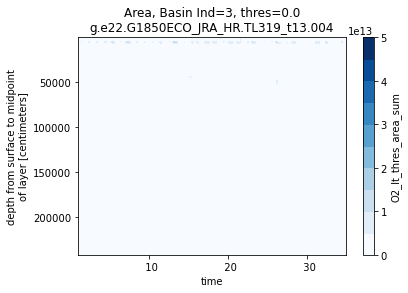

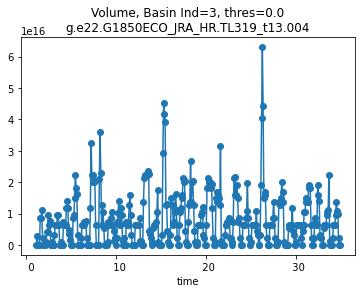

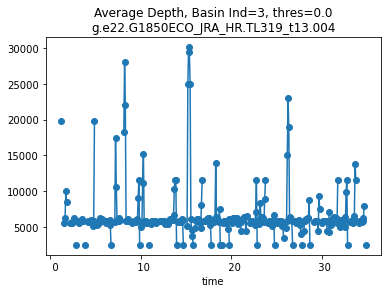

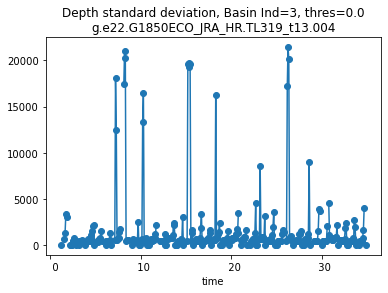

{'region_mask': 3, 'thres': 5.0, 'z_t': slice(0.0, 250000.0, None)}


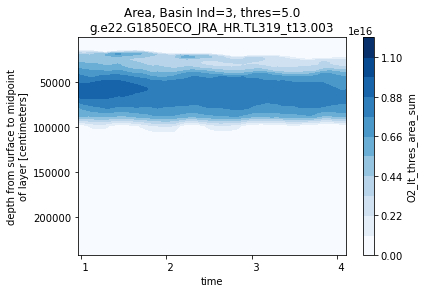

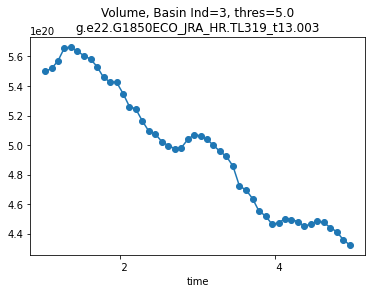

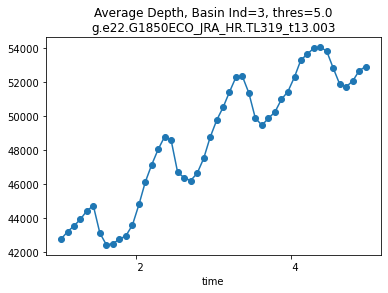

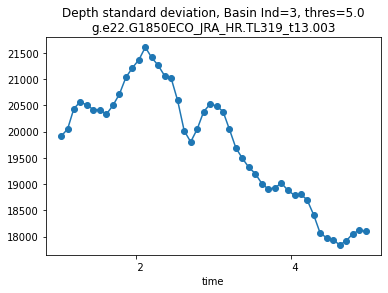

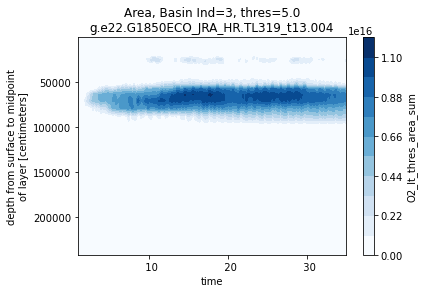

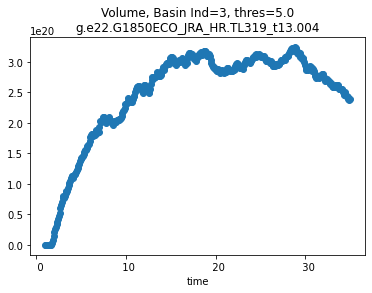

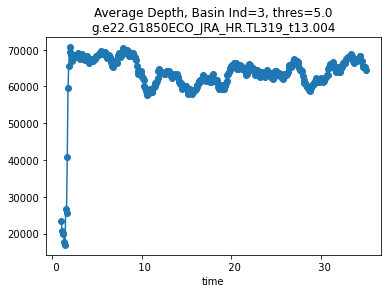

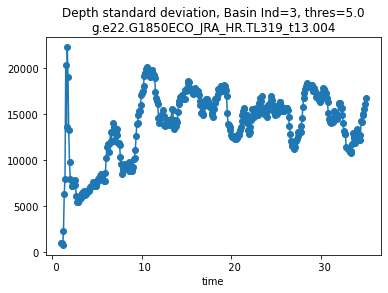

{'region_mask': 3, 'thres': 10.0, 'z_t': slice(0.0, 250000.0, None)}


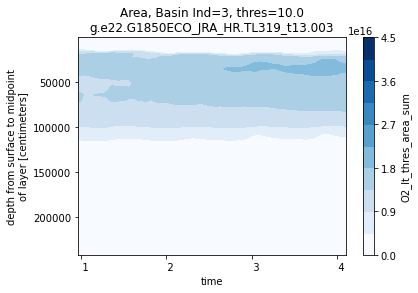

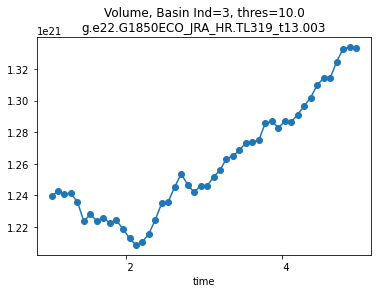

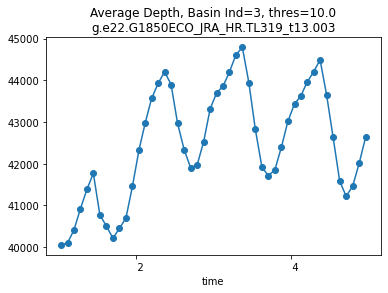

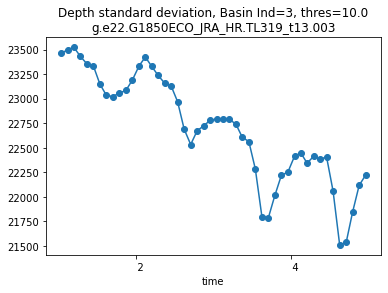

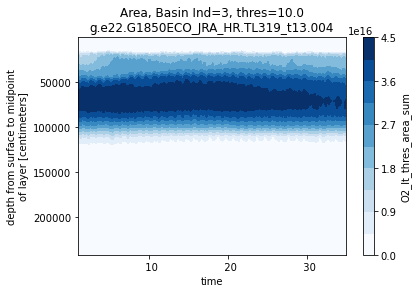

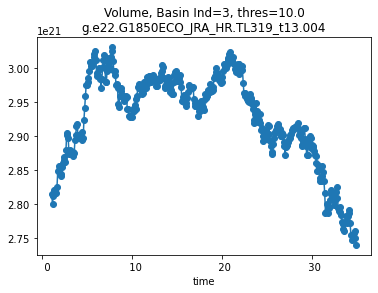

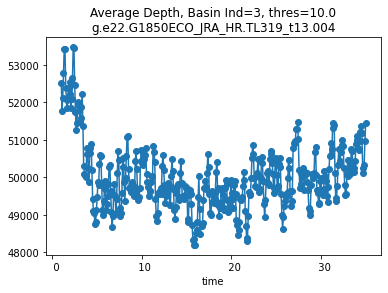

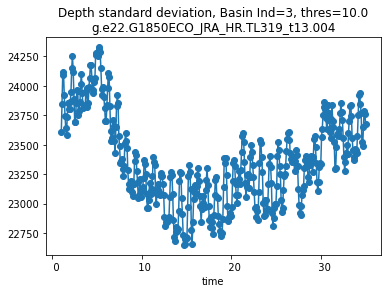

{'region_mask': 3, 'thres': 40.0, 'z_t': slice(0.0, 250000.0, None)}


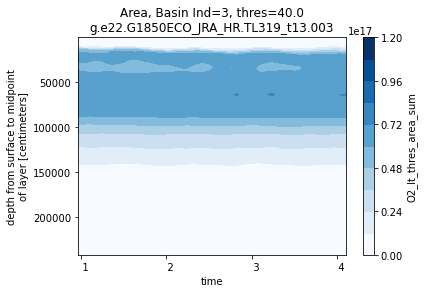

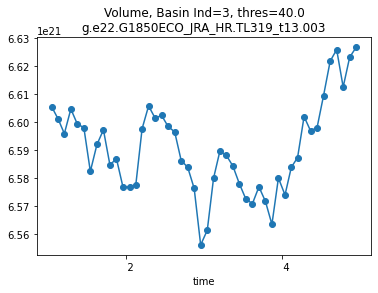

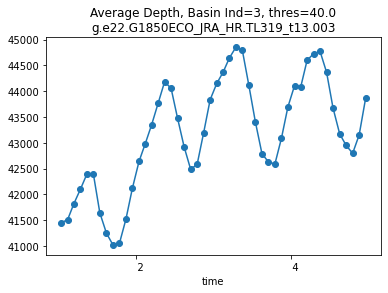

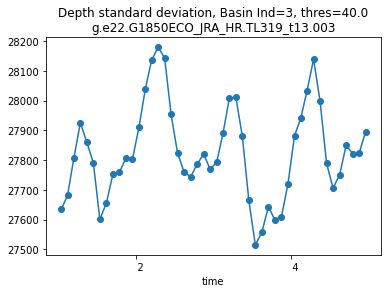

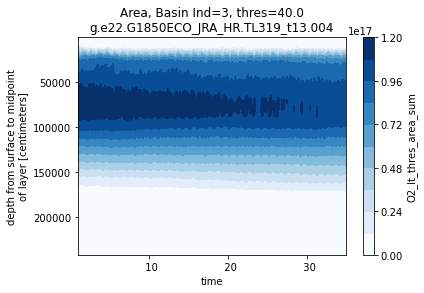

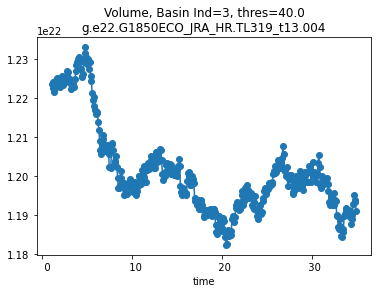

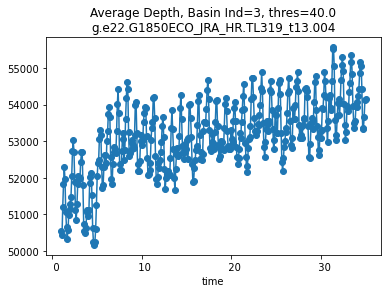

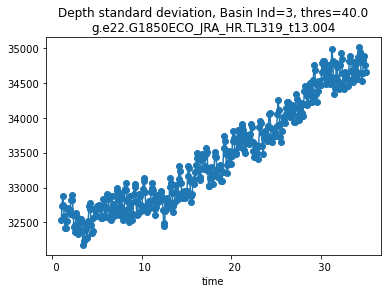

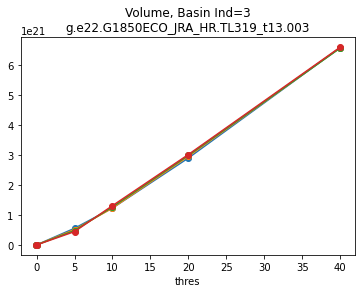

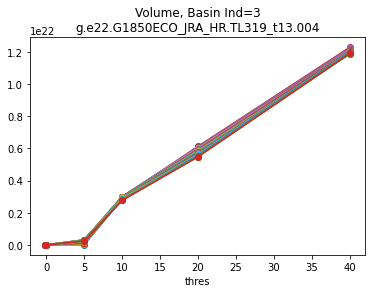

In [10]:
omz_plot(varname, region_mask_val=3)

{'region_mask': 6, 'thres': 0.0, 'z_t': slice(0.0, 250000.0, None)}


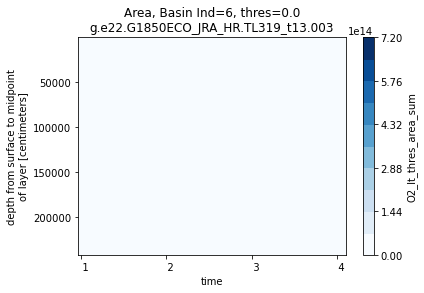

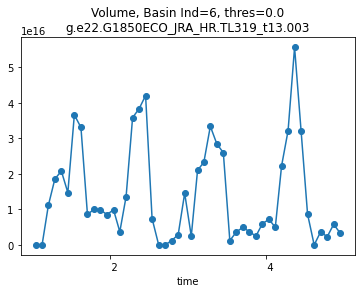

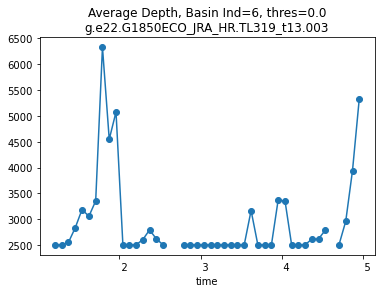

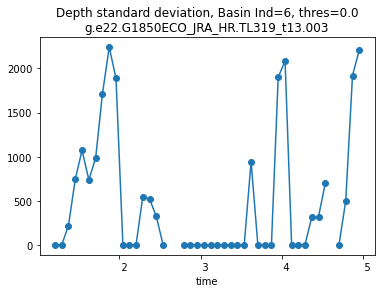

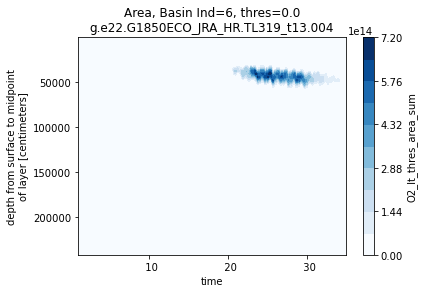

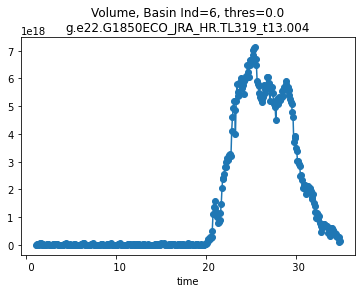

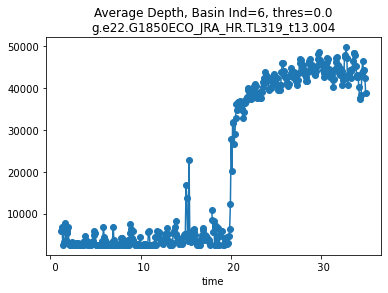

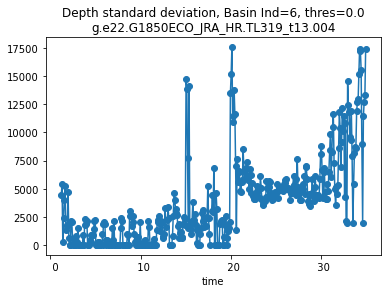

{'region_mask': 6, 'thres': 5.0, 'z_t': slice(0.0, 250000.0, None)}


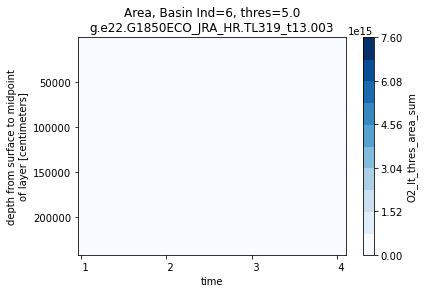

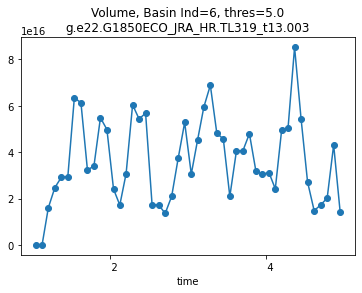

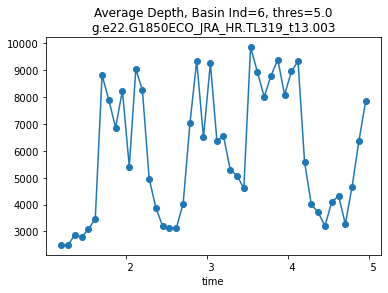

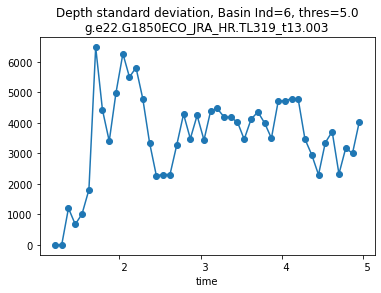

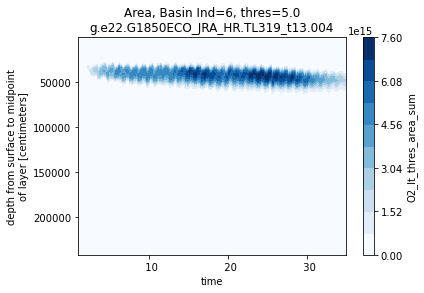

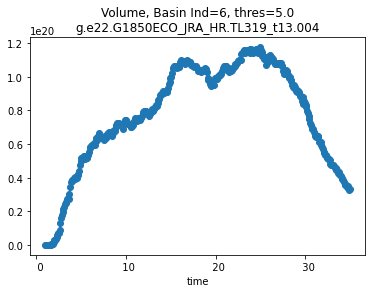

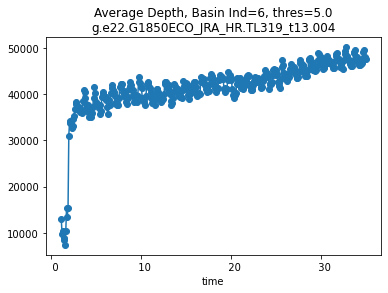

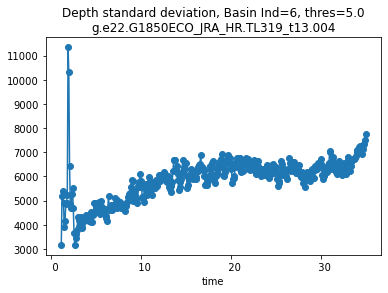

{'region_mask': 6, 'thres': 10.0, 'z_t': slice(0.0, 250000.0, None)}


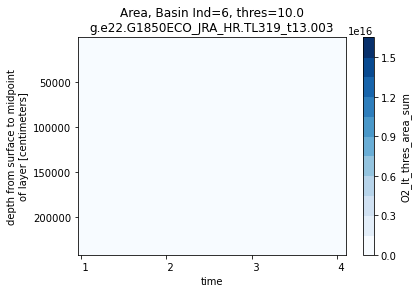

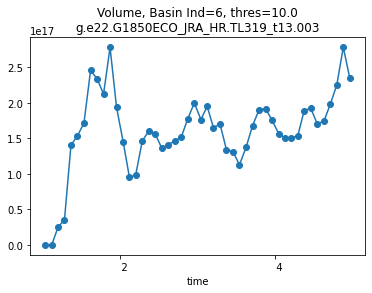

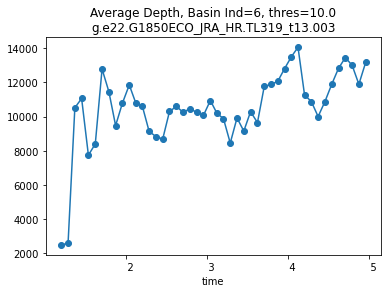

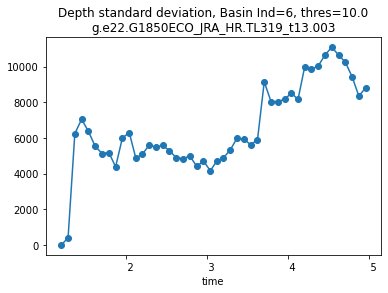

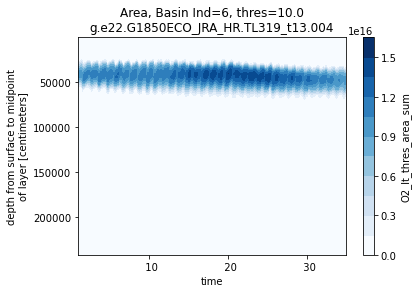

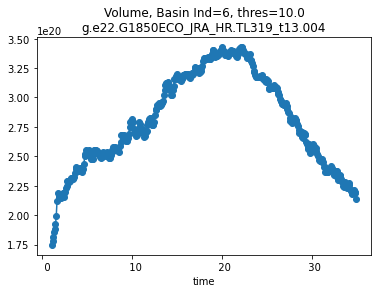

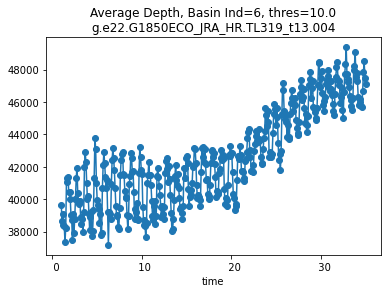

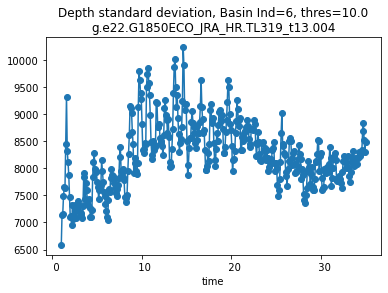

{'region_mask': 6, 'thres': 40.0, 'z_t': slice(0.0, 250000.0, None)}


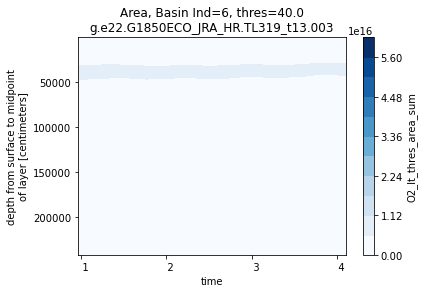

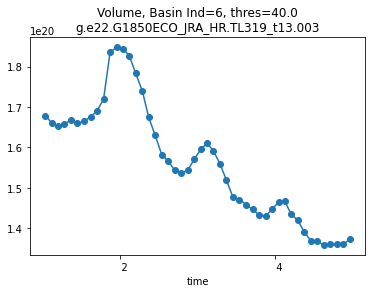

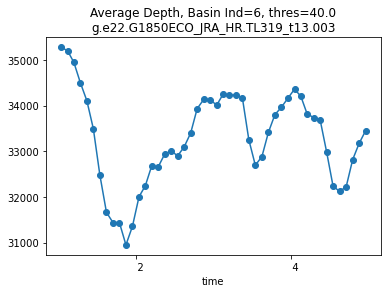

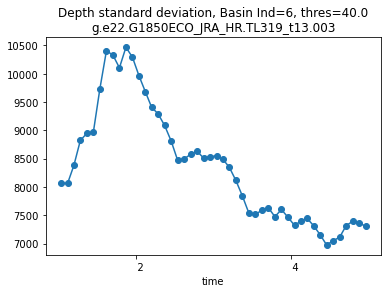

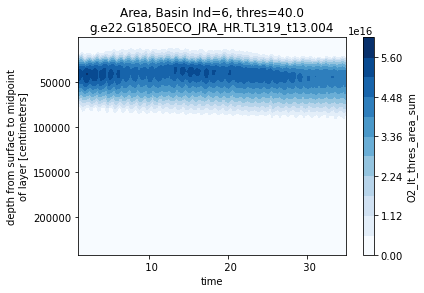

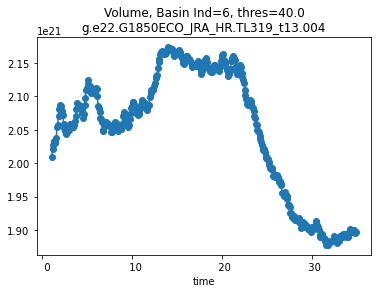

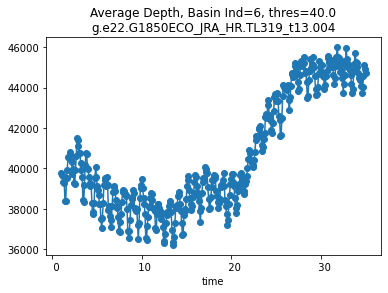

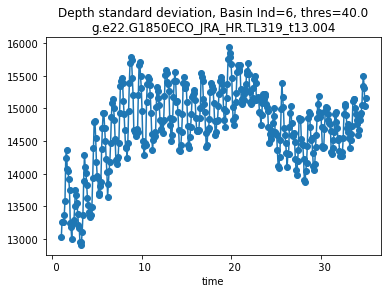

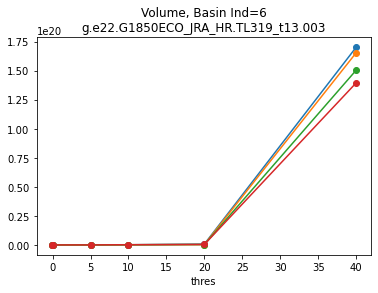

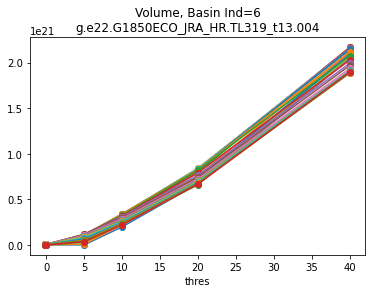

In [11]:
omz_plot(varname, region_mask_val=6)